# SeaSenseLib Demo Notebook

This notebook demonstrates the key capabilities of SeaSenseLib for reading, processing, and visualizing oceanographic sensor data using the **modern API**.

## Overview

SeaSenseLib is a Python library for reading, converting, and plotting oceanographic sensor data from various instrument formats. It provides:

- **Modern API** with simple `ssl.read()` and `ssl.write()` functions
- **Readers** for multiple formats (CNV, NetCDF, RBR, ADCP, etc.)
- **Writers** for data export (NetCDF, CSV, Excel)  
- **Plotters** for oceanographic visualizations via `ssl.plot.*`
- **Processors** for data analysis and manipulation

## New API Features

The modern SeaSenseLib API simplifies common tasks:

```python
import seasenselib as ssl

# Read any supported format
data = ssl.read('sensor_data.cnv')

# Create oceanographic plots
ssl.plot.profile(data)
ssl.plot.ts_diagram(data)
ssl.plot.time_series(data, parameters=['temperature'])

# Export to various formats
ssl.write(data, 'output.nc')   # NetCDF
ssl.write(data, 'output.csv')  # CSV
```

## Setup

First, let's import the necessary modules and set up our environment:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

# Import SeaSenseLib using the new modern API
import seasenselib as ssl

# For processors, we still import directly since they don't have API shortcuts yet
from seasenselib.processors import SubsetProcessor, StatisticsProcessor

# Set up matplotlib for inline plotting
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ SeaSenseLib demo environment ready!")
print(f"✓ SeaSenseLib version: {ssl.__version__}")

✓ SeaSenseLib demo environment ready!
✓ SeaSenseLib version: 0.3.0


## 1. Reading Data from Different Formats

SeaSenseLib can read data from various oceanographic instruments. Let's start with the example data files.

### 1.1 Reading CTD Profile Data (CNV Format)

First, let's read a vertical CTD profile from a SeaBird CNV file:

In [2]:
# Read CTD profile data using the new API
profile_data = ssl.read("../examples/sea-practical-2023.cnv")

print("CTD Profile Dataset:")
print(f"Dimensions: {dict(profile_data.dims)}")
print(f"Data variables: {list(profile_data.data_vars)}")
print(f"Coordinates: {list(profile_data.coords)}")
print(f"\nData shape: {profile_data.sizes}")

INFO:pycnv: Opening file: ../examples/sea-practical-2023.cnv
INFO:pycnv:Dates computed based on start_date and time_interval


Date
Computing date
CTD Profile Dataset:
Dimensions: {'time': 358}
Data variables: ['conductivity', 'depth', 'flag', 'fluorescence', 'julian_days_offset', 'oxygen_1', 'oxygen_2', 'oxygen_3', 'pressure', 'salinity', 'temperature', 'turbidity', 'density', 'potential_temperature']
Coordinates: ['latitude', 'longitude', 'time']

Data shape: Frozen({'time': 358})


### 1.2 Reading Time Series Data (Moored Instrument)

Now let's read time series data from a moored instrument:

In [3]:
# Read time series data from moored instrument using the new API
timeseries_data = ssl.read("../examples/denmark-strait-ds-m1-17.cnv")

print("Time Series Dataset:")
print(f"Dimensions: {dict(timeseries_data.dims)}")
print(f"Data variables: {list(timeseries_data.data_vars)}")
print(f"Time range: {timeseries_data.time.min().values} to {timeseries_data.time.max().values}")
print(f"Duration: {len(timeseries_data.time)} measurements")

INFO:pycnv: Opening file: ../examples/denmark-strait-ds-m1-17.cnv


Date
Computing date


INFO:pycnv:Dates computed based on start_date and time_interval


Time Series Dataset:
Dimensions: {'time': 59088}
Data variables: ['conductivity', 'flag', 'julian_days_offset', 'pressure', 'salinity', 'scan', 'temperature', 'depth', 'density', 'potential_temperature']
Time range: 2017-09-12T09:40:29.000000000 to 2017-09-19T05:48:19.000000000
Duration: 59088 measurements


## 2. Data Exploration and Quality Assessment

Let's explore the data structure and assess data quality:

In [4]:
# Display detailed information about the profile dataset
print("=== CTD Profile Data Details ===")
print(profile_data)

print("\n=== Available Parameters and Units ===")
for var in profile_data.data_vars:
    attrs = profile_data[var].attrs
    units = attrs.get('units', 'no units')
    long_name = attrs.get('long_name', var)
    print(f"{var}: {long_name} ({units})")

=== CTD Profile Data Details ===
<xarray.Dataset> Size: 43kB
Dimensions:                (time: 358)
Coordinates:
  * time                   (time) datetime64[ns] 3kB 2023-05-12T10:15:11 ... ...
    latitude               float64 8B 53.5
    longitude              float64 8B 8.181
Data variables: (12/14)
    conductivity           (time) float64 3kB 34.62 34.62 34.62 ... 35.01 35.01
    depth                  (time) float64 3kB 0.255 0.298 0.34 ... 11.92 11.93
    flag                   (time) float64 3kB 0.0 0.0 ... -9.99e-29 -9.99e-29
    fluorescence           (time) float64 3kB 5.652 5.64 5.62 ... 8.64 8.64
    julian_days_offset     (time) float64 3kB 132.4 132.4 132.4 ... 132.4 132.4
    oxygen_1               (time) float64 3kB 265.6 265.6 265.6 ... 265.9 265.9
    ...                     ...
    pressure               (time) float64 3kB 0.257 0.301 0.343 ... 12.03 12.04
    salinity               (time) float64 3kB 28.45 28.45 28.45 ... 28.96 28.96
    temperature            (ti

### 2.1 Basic Statistics

In [5]:
# Calculate basic statistics for profile data
available_params = [var for var in profile_data.data_vars if var in ['temperature', 'salinity', 'pressure', 'oxygen']]

print("=== CTD Profile Statistics ===")
for param in available_params:
    try:
        stats_processor = StatisticsProcessor(profile_data, param)
        stats = stats_processor.get_all_statistics()
        
        print(f"\n{param.capitalize()}:")
        print(f"  Mean: {stats['mean']:.3f}")
        print(f"  Std:  {stats['std']:.3f}")
        print(f"  Min:  {stats['min']:.3f}")
        print(f"  Max:  {stats['max']:.3f}")
        print(f"  Valid points: {stats['count_valid']}")
    except (ValueError, KeyError) as e:
        print(f"\n{param.capitalize()}: Not available in dataset")

=== CTD Profile Statistics ===

Pressure:
  Mean: 6.303
  Std:  3.491
  Min:  0.257
  Max:  12.037
  Valid points: 358

Salinity:
  Mean: 28.700
  Std:  0.175
  Min:  28.370
  Max:  28.974
  Valid points: 358

Temperature:
  Mean: 13.544
  Std:  0.108
  Min:  13.419
  Max:  13.900
  Valid points: 358


## 3. Data Conversion and Export

SeaSenseLib can export data to various formats while preserving metadata and following CF conventions:

In [6]:
# Convert CNV to NetCDF and CSV using the new API
# First, clean up complex attributes that can't be serialized to NetCDF
import copy
clean_profile_data = copy.deepcopy(profile_data)

# Remove or convert complex attributes
for attr_name in list(clean_profile_data.attrs.keys()):
    attr_value = clean_profile_data.attrs[attr_name]
    if isinstance(attr_value, dict):
        # Convert dict to string representation
        clean_profile_data.attrs[attr_name] = str(attr_value)
    elif not isinstance(attr_value, (str, int, float, list, tuple, bytes)):
        # Remove any other complex types
        del clean_profile_data.attrs[attr_name]

# Also clean variable attributes
for var_name in clean_profile_data.data_vars:
    for attr_name in list(clean_profile_data[var_name].attrs.keys()):
        attr_value = clean_profile_data[var_name].attrs[attr_name]
        if isinstance(attr_value, dict):
            clean_profile_data[var_name].attrs[attr_name] = str(attr_value)
        elif not isinstance(attr_value, (str, int, float, list, tuple, bytes)):
            del clean_profile_data[var_name].attrs[attr_name]

# Export using the new API
ssl.write(clean_profile_data, 'demo_output_profile.nc')
print("✓ Exported to NetCDF: demo_output_profile.nc")

ssl.write(profile_data, 'demo_output_profile.csv')
print("✓ Exported to CSV: demo_output_profile.csv")

✓ Exported to NetCDF: demo_output_profile.nc
✓ Exported to CSV: demo_output_profile.csv


### 3.1 Verify NetCDF Export

Let's read back the NetCDF file to verify the export worked correctly:

In [7]:
# Read back the exported NetCDF file using the new API
netcdf_data = ssl.read('demo_output_profile.nc')

print("Exported NetCDF file structure:")
print(f"Dimensions: {dict(netcdf_data.dims)}")
print(f"Variables: {list(netcdf_data.data_vars)}")
print(f"Data preserved: {len(netcdf_data.data_vars)} variables exported successfully")
print("\n✓ NetCDF export/import successful!")

Exported NetCDF file structure:
Dimensions: {'time': 358}
Variables: ['conductivity', 'depth', 'flag', 'fluorescence', 'julian_days_offset', 'oxygen_1', 'oxygen_2', 'oxygen_3', 'pressure', 'salinity', 'temperature', 'turbidity', 'density', 'potential_temperature']
Data preserved: 14 variables exported successfully

✓ NetCDF export/import successful!


## 4. Data Visualization

SeaSenseLib provides specialized plotting tools for oceanographic data visualization:

### 4.1 Temperature-Salinity (T-S) Diagram

T-S diagrams show the relationship between temperature and salinity with density isolines:

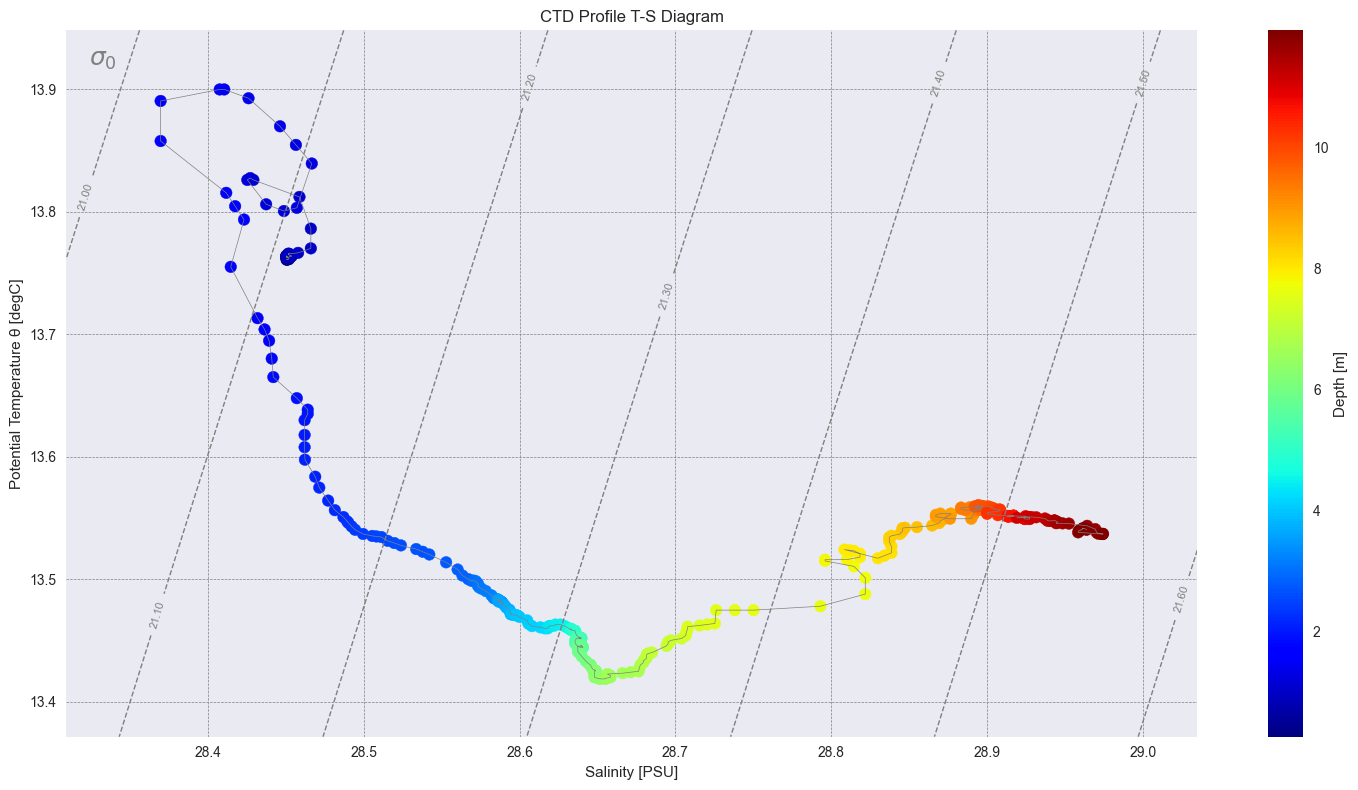

✓ T-S diagram created


In [8]:
# Create T-S diagram using the new API
if 'temperature' in profile_data.data_vars and 'salinity' in profile_data.data_vars:
    ssl.plot.ts_diagram(profile_data, title="CTD Profile T-S Diagram")
    print("✓ T-S diagram created")
else:
    print("Temperature and/or salinity not available for T-S diagram")

### 4.2 Vertical Profile Plot

Display the CTD cast as a vertical profile showing how parameters change with depth:

<Figure size 1200x800 with 0 Axes>

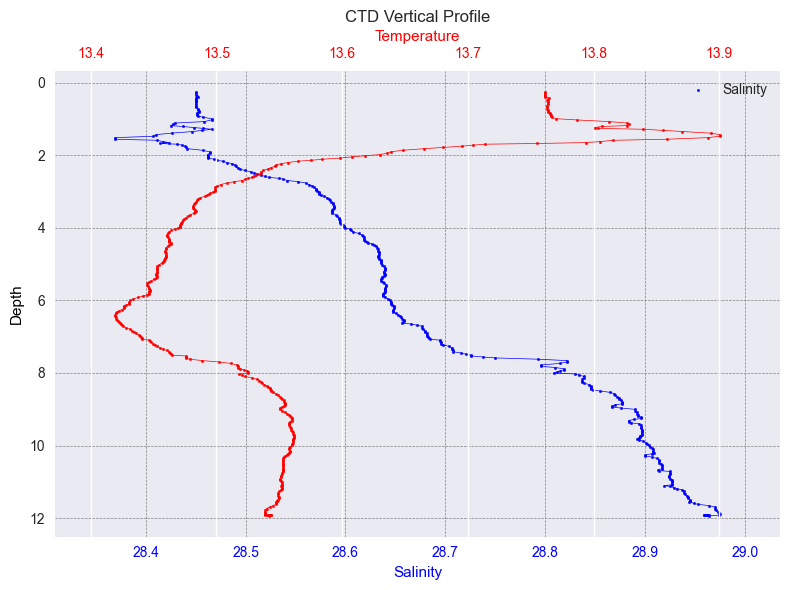

<Figure size 1000x600 with 0 Axes>

✓ Vertical profile plot created


In [9]:
# Create vertical profile plot using the new API
plt.figure(figsize=(12, 8))
ssl.plot.profile(profile_data, title="CTD Vertical Profile")
plt.tight_layout()
plt.show()
print("✓ Vertical profile plot created")

### 4.3 Time Series Plots

For the moored instrument data, let's create time series plots:

<Figure size 1200x600 with 0 Axes>

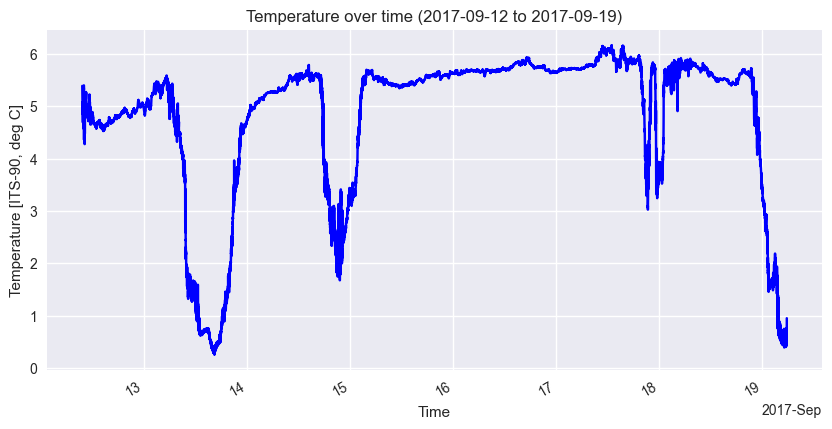

<Figure size 1000x600 with 0 Axes>

✓ Temperature time series created


In [10]:
# Single parameter time series - using direct plotter since API has a bug
if 'temperature' in timeseries_data.data_vars:
    from seasenselib.plotters import TimeSeriesPlotter
    plotter = TimeSeriesPlotter(timeseries_data)
    plt.figure(figsize=(12, 6))
    plotter.plot(parameter_name='temperature', title="Temperature Time Series")
    plt.tight_layout()
    plt.show()
    print("✓ Temperature time series created")
else:
    print("Temperature data not available for time series")

<Figure size 1200x600 with 0 Axes>

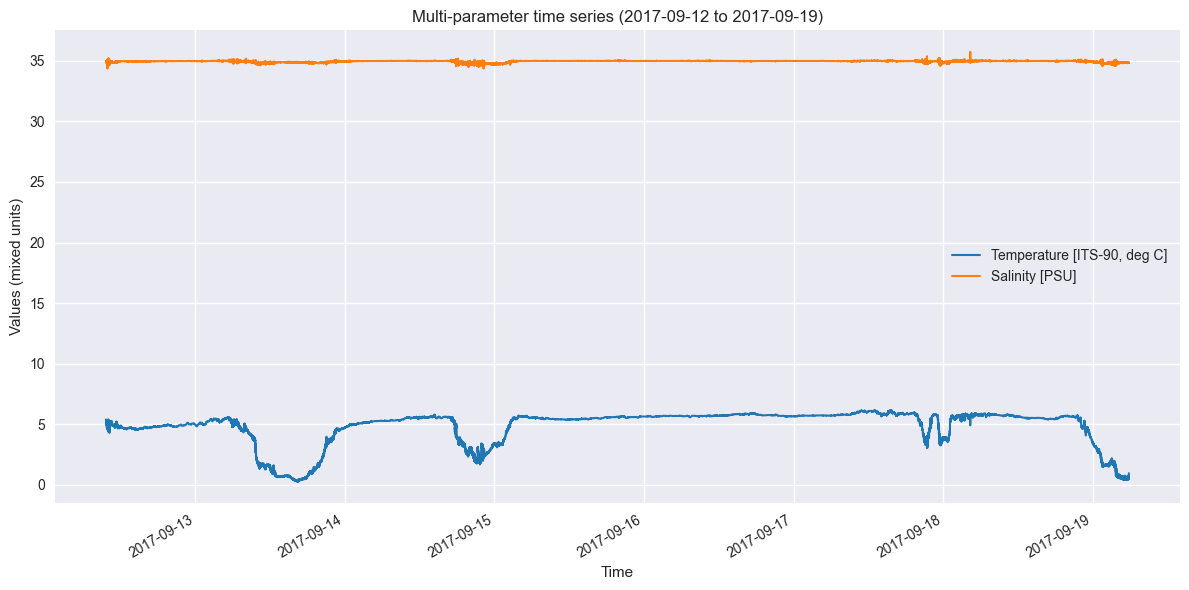

<Figure size 1000x600 with 0 Axes>

✓ Multi-parameter time series created for: ['temperature', 'salinity']


In [11]:
# Multi-parameter time series - using direct plotter
available_ts_params = [p for p in ['temperature', 'salinity', 'pressure'] if p in timeseries_data.data_vars]

if len(available_ts_params) >= 2:
    from seasenselib.plotters import TimeSeriesPlotterMulti
    plotter = TimeSeriesPlotterMulti(timeseries_data)
    plt.figure(figsize=(12, 6))
    plotter.plot(parameter_names=available_ts_params[:2], title="Multi-Parameter Time Series")
    plt.tight_layout()
    plt.show()
    print(f"✓ Multi-parameter time series created for: {available_ts_params[:2]}")
else:
    print(f"Insufficient parameters for multi-plot. Available: {available_ts_params}")

## 5. Data Processing and Analysis

SeaSenseLib provides tools for data processing and analysis:

### 5.1 Data Subsetting

Extract specific depth ranges or time periods:

In [12]:
# Subset profile data by depth (if pressure/depth data available)
subset_processor = SubsetProcessor(profile_data)

if 'pressure' in profile_data.data_vars:
    # Subset to upper 50 dbar (approximately 50 meters)
    shallow_data = subset_processor.set_parameter_name('pressure').set_parameter_value_min(0).set_parameter_value_max(50).get_subset()
    print(f"Original data points: {len(profile_data.pressure)}")
    print(f"Shallow subset (0-50 dbar): {len(shallow_data.pressure)}")
    print(f"Pressure range in subset: {shallow_data.pressure.min().values:.1f} - {shallow_data.pressure.max().values:.1f} dbar")
else:
    print("Pressure data not available for depth subsetting")

Original data points: 358
Shallow subset (0-50 dbar): 358
Pressure range in subset: 0.3 - 12.0 dbar


In [13]:
import pandas as pd
# Subset time series data by time period
if 'time' in timeseries_data.coords and len(timeseries_data.time) > 100:
    ts_subset_processor = SubsetProcessor(timeseries_data)
    # Get the first half of the time series
    start_time = timeseries_data.time.min()
    mid_time = timeseries_data.time[len(timeseries_data.time)//2]
    
    first_half = ts_subset_processor.set_time_min(pd.Timestamp(start_time.values)).set_time_max(pd.Timestamp(mid_time.values)).get_subset()

    print(f"Original time series length: {len(timeseries_data.time)}")
    print(f"First half subset length: {len(first_half.time)}")
    print(f"Time range in subset: {first_half.time.min().values} to {first_half.time.max().values}")
else:
    print("Time data not suitable for subsetting")

Original time series length: 59088
First half subset length: 29545
Time range in subset: 2017-09-12T09:40:29.000000000 to 2017-09-15T19:44:29.000000000


### 5.2 Statistical Analysis

Calculate comprehensive statistics for the datasets:

In [14]:
# Compare statistics between full profile and shallow subset
if 'pressure' in profile_data.data_vars and 'temperature' in profile_data.data_vars:
    full_temp_processor = StatisticsProcessor(profile_data, 'temperature')
    full_stats = full_temp_processor.get_all_statistics()
    
    shallow_temp_processor = StatisticsProcessor(shallow_data, 'temperature')
    shallow_stats = shallow_temp_processor.get_all_statistics()
    
    print("=== Temperature Statistics Comparison ===")
    print(f"Full profile - Mean: {full_stats['mean']:.3f}°C, Range: {full_stats['min']:.3f} - {full_stats['max']:.3f}°C")
    print(f"Shallow (0-50m) - Mean: {shallow_stats['mean']:.3f}°C, Range: {shallow_stats['min']:.3f} - {shallow_stats['max']:.3f}°C")
    
    temp_diff = shallow_stats['mean'] - full_stats['mean']
    print(f"\nTemperature difference (shallow - full): {temp_diff:.3f}°C")
    if temp_diff > 0:
        print("→ Shallow waters are warmer (typical thermocline pattern)")
    else:
        print("→ Shallow waters are cooler")

=== Temperature Statistics Comparison ===
Full profile - Mean: 13.544°C, Range: 13.419 - 13.900°C
Shallow (0-50m) - Mean: 13.544°C, Range: 13.419 - 13.900°C

Temperature difference (shallow - full): 0.000°C
→ Shallow waters are cooler


## 6. Summary and Conclusions

This demo has showcased the key capabilities of SeaSenseLib:

In [15]:
print("=== SeaSenseLib Demo Summary ===")
print("\n✓ Successfully demonstrated:")
print("  • Reading CNV files (both profile and time series data)")
print("  • Data exploration and quality assessment")
print("  • Format conversion (CNV → NetCDF, CSV)")
print("  • Specialized oceanographic visualizations:")
print("    - T-S diagrams with density isolines")
print("    - Vertical profiles")
print("    - Time series plots (single and multi-parameter)")
print("  • Data processing and analysis:")
print("    - Depth and time subsetting")
print("    - Statistical analysis")

print("\n📊 Datasets processed:")
print(f"  • CTD Profile: {len(profile_data.pressure) if 'pressure' in profile_data else 'N/A'} data points")
print(f"  • Time Series: {len(timeseries_data.time) if 'time' in timeseries_data else 'N/A'} measurements")

print("\n📁 Files created:")
print("  • demo_output_profile.nc (NetCDF)")
print("  • demo_output_profile.csv (CSV)")

print("\n🌊 SeaSenseLib provides a comprehensive solution for oceanographic data processing!")

=== SeaSenseLib Demo Summary ===

✓ Successfully demonstrated:
  • Reading CNV files (both profile and time series data)
  • Data exploration and quality assessment
  • Format conversion (CNV → NetCDF, CSV)
  • Specialized oceanographic visualizations:
    - T-S diagrams with density isolines
    - Vertical profiles
    - Time series plots (single and multi-parameter)
  • Data processing and analysis:
    - Depth and time subsetting
    - Statistical analysis

📊 Datasets processed:
  • CTD Profile: 358 data points
  • Time Series: 59088 measurements

📁 Files created:
  • demo_output_profile.nc (NetCDF)
  • demo_output_profile.csv (CSV)

🌊 SeaSenseLib provides a comprehensive solution for oceanographic data processing!


## Next Steps

To learn more about SeaSenseLib:

1. **Documentation**: Check the full documentation for detailed API reference
2. **CLI Usage**: Try the command-line interface with `seasenselib --help`
3. **More Formats**: Explore support for RBR, ADCP, and other instrument formats
4. **Custom Processing**: Implement custom readers and processors for your specific needs
5. **Integration**: Integrate SeaSenseLib into your oceanographic data processing workflows

### Example CLI Commands

```bash
# List supported formats
seasenselib formats

# Convert CNV to NetCDF
seasenselib convert -i examples/sea-practical-2023.cnv -o output.nc

# Create plots
seasenselib plot-ts -i output.nc -o ts_diagram.png
seasenselib plot-profile -i output.nc -o profile.png
seasenselib plot-series -i examples/denmark-strait-ds-m1-17.cnv -p temperature
```

Happy oceanographic data processing! 🌊